In [27]:
import numpy as np
import pandas as pd
import string
import re
import collections
from num2word import word
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

import time

# Import Data Set

Consists of class index 1-4 where 1-World, 2-Sports, 3-Business, 4-Sci/Tech

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data = pd.concat([train,test],axis=0)

In [3]:
print(train.shape,test.shape,data.shape)

(120000, 3) (7600, 3) (127600, 3)


In [4]:
data.head()

Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...

# Remove Punctuation and Stopwords 

In [5]:
data['Title'] = data['Title'].apply(lambda s: re.sub(r'[^a-z0-9]',' ',s.lower()))
data['Description'] = data['Description'].apply(lambda s: re.sub(r'[^a-z0-9]',' ',s.lower()))

In [6]:
def convert_num_to_word(words):
    result = []
    for w in words:
        if w.isnumeric():
            result.extend(map(lambda x: x.lower(),word(w).split()))
        else:
            result.append(w)
    return result

data['Title'] = data['Title'].str.split().apply(convert_num_to_word)
data['Description'] = data['Description'].str.split().apply(convert_num_to_word)

In [7]:
def remove_stopword(words):
    result = []
    for word in words:
        if word not in STOPWORDS:
            result.append(word)
    return result

data['Title'] = data['Title'].apply(remove_stopword)
data['Description'] = data['Description'].apply(remove_stopword)

In [8]:
def remove_single_character(words):
    result = []
    for word in words:
        if len(word) > 1:
            result.append(word)
    return result  

data['Title'] = data['Title'].apply(remove_single_character)
data['Description'] = data['Description'].apply(remove_single_character)

# Lemmatization

In [9]:
def lemmatization(words):
    lemmatizer = WordNetLemmatizer()
    result = []
    for word in words:
        result.append(lemmatizer.lemmatize(word))
    return result

data['Title'] = data['Title'].apply(lemmatization)
data['Description'] = data['Description'].apply(lemmatization)

In [10]:
data['Title'] = data['Title'].apply(convert_num_to_word)
data['Description'] = data['Description'].apply(convert_num_to_word)
data['Title'] = data['Title'].apply(remove_stopword)
data['Description'] = data['Description'].apply(remove_stopword)
data['Title'] = data['Title'].apply(remove_single_character)
data['Description'] = data['Description'].apply(remove_single_character)

# Combine Title and Description

In [11]:
data['Documents'] = data['Title'] + data['Description']

In [12]:
data['Word Count'] = data['Documents'].apply(lambda x: len(x))

In [13]:
data.head()

Class Index                                              Title  \
0            3       [wall, st, bear, claw, back, black, reuters]   
1            3  [carlyle, look, toward, commercial, aerospace,...   
2            3     [oil, economy, cloud, stock, outlook, reuters]   
3            3  [iraq, halt, oil, export, main, southern, pipe...   
4            3  [oil, price, soar, time, record, posing, new, ...   

                                         Description  \
0  [reuters, short, seller, wall, street, dwindli...   
1  [reuters, private, investment, firm, carlyle, ...   
2  [reuters, soaring, crude, price, plus, worry, ...   
3  [reuters, authority, halted, oil, export, flow...   
4  [afp, tearaway, world, oil, price, toppling, r...   

                                           Documents  Word Count  
0  [wall, st, bear, claw, back, black, reuters, r...          18  
1  [carlyle, look, toward, commercial, aerospace,...          27  
2  [oil, economy, cloud, stock, outlook, reuters,...          24  
3  [iraq, halt, oil, export, main, southern, pipe...          28  
4  [oil, price, soar, time, record, posing, new, ...          28

# Convert List to String

In [14]:
data['Documents'] = data['Documents'].apply(lambda x: ' '.join(map(str,x)))
data.drop(['Title','Description'],axis=1,inplace=True)

# Create Features 
### count: noun phrase, noun, verb, adjective

In [22]:
data['Noun Phrases'] = data['Documents'].apply(lambda x: len(TextBlob(x).noun_phrases))

In [23]:
data['Tags'] = data['Documents'].apply(lambda t: collections.Counter(tag for word,tag in TextBlob(t).tags))

In [24]:
# pos tag list https://pythonprogramming.net/part-of-speech-tagging-nltk-tutorial/

data['Noun Count'] = data['Tags'].apply(lambda d: d.get('NN',0)+d.get('NNS',0)+d.get('NNP',0)+d.get('NNPS',0))
data['Adjective Count'] = data['Tags'].apply(lambda d: d.get('JJ',0)+d.get('JJR',0)+d.get('JJS',0))
data['Verb Count'] = data['Tags'].apply(lambda d: d.get('VB',0)+d.get('VBD',0)+d.get('VBG',0)+d.get('VBN',0)+d.get('VBP',0)+d.get('VBZ',0))

# Export Cleaned Data as CSV

In [25]:
data.to_csv('cleaned_AG.csv1',index=False)

# Import Datatset

In [26]:
data = pd.read_csv('cleaned_AG.csv1',index_col=None)

In [27]:
data.head()

Class Index                                          Documents  Word Count  \
0            3  wall st bear claw back black reuters reuters s...          18   
1            3  carlyle look toward commercial aerospace reute...          27   
2            3  oil economy cloud stock outlook reuters reuter...          24   
3            3  iraq halt oil export main southern pipeline re...          28   
4            3  oil price soar time record posing new menace e...          28   

   Noun Phrases                                               Tags  \
0             4  Counter({'NN': 10, 'JJ': 3, 'NNS': 2, 'RB': 1,...   
1             5  Counter({'NN': 13, 'JJ': 4, 'RB': 3, 'NNS': 2,...   
2             5  Counter({'NN': 13, 'NNS': 4, 'JJ': 4, 'VBG': 1...   
3             3  Counter({'NN': 17, 'JJ': 6, 'NNS': 2, 'VBD': 2...   
4             4  Counter({'NN': 16, 'JJ': 7, 'VBG': 2, 'VB': 1,...   

   Noun Count  Adjective Count  Verb Count  
0          12                3           2  
1          15                4           3  
2          17                4           2  
3          19                6           3  
4          16                7           3

# Feature Extraction: Bag of Words

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(data['Documents'])

denselist = X.todense().tolist()
df = pd.DataFrame(denselist, columns=vectorizer.get_feature_names())
bag_of_words = pd.concat([data[['Class Index','Word Count','Noun Phrases','Noun Count','Adjective Count','Verb Count']],df],axis=1)
bag_of_words.head()

Class Index  Word Count  Noun Phrases  Noun Count  Adjective Count  \
0            3          18             4          12                3   
1            3          27             5          15                4   
2            3          24             5          17                4   
3            3          28             3          19                6   
4            3          28             4          16                7   

   Verb Count  access  according  accused  acquisition  ...  yahoo  yankee  \
0           2       0          0        0            0  ...      0       0   
1           3       0          0        0            0  ...      0       0   
2           2       0          0        0            0  ...      0       0   
3           3       0          0        0            0  ...      0       0   
4           3       0          0        0            0  ...      0       0   

   yard  yasser  year  yesterday  yet  york  young  yukos  
0     0       0     0          0    0     0      0      0  
1     0       0     0          0    0     0      0      0  
2     0       0     0          0    0     0      0      0  
3     0       0     0          0    0     0      0      0  
4     0       0     0          0    0     0      0      0  

[5 rows x 1006 columns]

In [32]:
bag_of_words.describe()

Class Index     Word Count   Noun Phrases     Noun Count  \
count  127600.000000  127600.000000  127600.000000  127600.000000   
mean        2.500000      27.762782       4.545603      14.583918   
std         1.118038       8.416453       1.557606       5.005073   
min         1.000000       3.000000       0.000000       1.000000   
25%         1.750000      23.000000       3.000000      11.000000   
50%         2.500000      27.000000       4.000000      14.000000   
75%         3.250000      32.000000       5.000000      17.000000   
max         4.000000     172.000000      20.000000      91.000000   

       Adjective Count     Verb Count         access      according  \
count    127600.000000  127600.000000  127600.000000  127600.000000   
mean          5.458370       4.436732       0.007751       0.020737   
std           2.560175       2.016883       0.099817       0.143215   
min           0.000000       0.000000       0.000000       0.000000   
25%           4.000000       3.000000       0.000000       0.000000   
50%           5.000000       4.000000       0.000000       0.000000   
75%           7.000000       6.000000       0.000000       0.000000   
max          28.000000      29.000000       5.000000       2.000000   

             accused    acquisition  ...          yahoo         yankee  \
count  127600.000000  127600.000000  ...  127600.000000  127600.000000   
mean        0.008260       0.005180  ...       0.008260       0.011638   
std         0.096624       0.078863  ...       0.142671       0.139573   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.000000       0.000000  ...       0.000000       0.000000   
50%         0.000000       0.000000  ...       0.000000       0.000000   
75%         0.000000       0.000000  ...       0.000000       0.000000   
max         3.000000       2.000000  ...      10.000000       6.000000   

                yard         yasser           year      yesterday  \
count  127600.000000  127600.000000  127600.000000  127600.000000   
mean        0.009451       0.005948       0.120956       0.050682   
std         0.114491       0.078908       0.371721       0.220239   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         5.000000       2.000000       9.000000       2.000000   

                 yet           york          young          yukos  
count  127600.000000  127600.000000  127600.000000  127600.000000  
mean        0.007539       0.052194       0.005415       0.006144  
std         0.088649       0.241346       0.080226       0.110328  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000       0.000000  
max         2.000000       4.000000       3.000000       3.000000  

[8 rows x 1006 columns]

In [33]:
bag_of_words.to_csv('bag_of_words.csv',index=False)

## Model Training 

In [2]:
data = pd.read_csv('bag_of_words.csv')
# X dataframe 
X = data.drop(['Class Index'],axis=1) 
# y series
y = data['Class Index']

In [3]:
pca = PCA(n_components=100)
X = pca.fit_transform(X)

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [5]:
svc = SVC()

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
svc_acc = []

start = time.time()

for train_index, vaild_index in skf.split(X_train,y_train):
    x_t, x_v = X_train[train_index], X_train[vaild_index]
    y_t, y_v = y_train[train_index], y_train[vaild_index]
    svc.fit(x_t, y_t)
    svc_acc.append(svc.score(x_v, y_v))

stop = time.time()
svm_tt = round((stop-start) / 60, 2)
print(f"Training time: {svm_tt}min")

Training time: 12.4min


In [6]:
print(svc_acc)

[0.8228392297357815, 0.8234885803851321]


In [7]:
print(np.mean(svc_acc))

0.8231639050604568


In [8]:
lr = LogisticRegression(solver='newton-cg')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lr_acc = []

start = time.time()
for train_index, vaild_index in skf.split(X_train,y_train):
    x_t, x_v = X_train[train_index], X_train[vaild_index]
    y_t, y_v = y_train[train_index], y_train[vaild_index]
    lr.fit(x_t, y_t)
    lr_acc.append(lr.score(x_v, y_v))
stop = time.time()
lr_tt = round((stop-start) / 60, 2)
print(f"Training time: {lr_tt}min")

Training time: 0.82min


In [9]:
print(lr_acc)

[0.8296574115539633, 0.831448723690103, 0.8250671742051052, 0.831448723690103, 0.8299932825794895]


In [10]:
print(np.mean(lr_acc))

0.8295230631437528


In [11]:
gnb = GaussianNB()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
gnb_acc = []

start=time.time()

for train_index, vaild_index in skf.split(X_train,y_train):
    x_t, x_v = X_train[train_index], X_train[vaild_index]
    y_t, y_v = y_train[train_index], y_train[vaild_index]
    gnb.fit(x_t, y_t)
    gnb_acc.append(gnb.score(x_v, y_v))
stop=time.time()

gnb_tt = round((stop-start) / 60, 2)
print(f"Training time: {gnb_tt}min")

Training time: 0.02min


In [12]:
print(gnb_acc)

[0.5918047469771608, 0.5943237796686073, 0.6016569637259293, 0.5951634572324227, 0.5940438871473355]


In [13]:
print(np.mean(gnb_acc))

0.5953985669502911


In [17]:
rf = RandomForestClassifier()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
rf_acc = []

start=time.time()

for train_index, vaild_index in skf.split(X_train,y_train):
    x_t, x_v = X_train[train_index], X_train[vaild_index]
    y_t, y_v = y_train[train_index], y_train[vaild_index]
    rf.fit(x_t, y_t)
    rf_acc.append(rf.score(x_v, y_v))
stop=time.time()

rf_tt = round((stop-start) / 60, 2)
print(f"Training time: {rf_tt}min")

Training time: 7.93min


In [18]:
print(rf_acc)

[0.7959023734885804, 0.8003246753246753, 0.7940550828481863, 0.7966300940438872, 0.7967980295566502]


In [19]:
print(np.mean(rf_acc))

0.7967420510523959


In [14]:
# Cross-validation is a resampling procedure used to evaluate machine 
# learning models on a limited data sample. (prevent generalization) 
# GridSearchCV for tuning hyperparameter with resampling 

## Model Evaluation

In [28]:
y_pred = lr.predict(X_test)

lr_acc = accuracy_score(y_test,y_pred)
lr_recall = recall_score(y_test,y_pred,average='micro')
lr_precision = precision_score(y_test,y_pred,average='micro')
lr_f1 = f1_score(y_test,y_pred,average='micro')

y_pred_roc = OneHotEncoder().fit_transform(y_pred.reshape(-1, 1)).toarray()
y_test_roc = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
lr_roc = roc_auc_score(y_test_roc,y_pred_roc,multi_class='ovo')

In [29]:
y_pred = gnb.predict(X_test)

gnb_acc = accuracy_score(y_test,y_pred)
gnb_recall = recall_score(y_test,y_pred,average='micro')
gnb_precision = precision_score(y_test,y_pred,average='micro')
gnb_f1 = f1_score(y_test,y_pred,average='micro')

y_pred_roc = OneHotEncoder().fit_transform(y_pred.reshape(-1, 1)).toarray()
y_test_roc = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
gnb_roc = roc_auc_score(y_test_roc,y_pred_roc,multi_class='ovo')

In [30]:
y_pred = svc.predict(X_test)

svc_acc = accuracy_score(y_test,y_pred)
svc_recall = recall_score(y_test,y_pred,average='micro')
svc_precision = precision_score(y_test,y_pred,average='micro')
svc_f1 = f1_score(y_test,y_pred,average='micro')

y_pred_roc = OneHotEncoder().fit_transform(y_pred.reshape(-1, 1)).toarray()
y_test_roc = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
svc_roc = roc_auc_score(y_test_roc,y_pred_roc,multi_class='ovo')

In [31]:
y_pred = rf.predict(X_test)

rf_acc = accuracy_score(y_test,y_pred)
rf_recall = recall_score(y_test,y_pred,average='micro')
rf_precision = precision_score(y_test,y_pred,average='micro')
rf_f1 = f1_score(y_test,y_pred,average='micro')

y_pred_roc = OneHotEncoder().fit_transform(y_pred.reshape(-1, 1)).toarray()
y_test_roc = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
rf_roc = roc_auc_score(y_test_roc,y_pred_roc,multi_class='ovo')

In [32]:
print("Logistic Regression: ",lr_acc,lr_recall,lr_precision,lr_f1,lr_roc)
print("Naive Bayes: ", gnb_acc,gnb_recall,gnb_precision,gnb_f1,gnb_roc)
print("Support Vector Machine: ", svc_acc,svc_recall,svc_precision,svc_f1,svc_roc)
print("Random Forest: ", rf_acc,rf_recall,rf_precision,rf_f1,rf_roc)

Logistic Regression:  0.831765935214211 0.831765935214211 0.831765935214211 0.831765935214211 0.8877502090107565
Naive Bayes:  0.6000522466039707 0.6000522466039707 0.6000522466039707 0.6000522466039707 0.7327206461098312
Support Vector Machine:  0.8250783699059561 0.8250783699059561 0.8250783699059561 0.825078369905956 0.8832968923317218
Random Forest:  0.7982236154649948 0.7982236154649948 0.7982236154649948 0.7982236154649948 0.8653306150745892


In [33]:
results = pd.DataFrame([[lr_acc,lr_recall,lr_precision,lr_f1,lr_roc],
                        [gnb_acc,gnb_recall,gnb_precision,gnb_f1,gnb_roc],
                        [svc_acc,svc_recall,svc_precision,svc_f1,svc_roc],
                        [rf_acc,rf_recall,rf_precision,rf_f1,rf_roc]],
                       columns=['accuracy','recall','precision','fl-score','roc_auc'], 
                       index=["Logistic Regression","Naive Bayes","Support Vector Machine","Random Forest"])

In [34]:
print(results)

                        accuracy    recall  precision  fl-score   roc_auc
Logistic Regression     0.831766  0.831766   0.831766  0.831766  0.887750
Naive Bayes             0.600052  0.600052   0.600052  0.600052  0.732721
Support Vector Machine  0.825078  0.825078   0.825078  0.825078  0.883297
Random Forest           0.798224  0.798224   0.798224  0.798224  0.865331


In [35]:
results.to_csv('bag_of_words_results.csv')

### Training Time

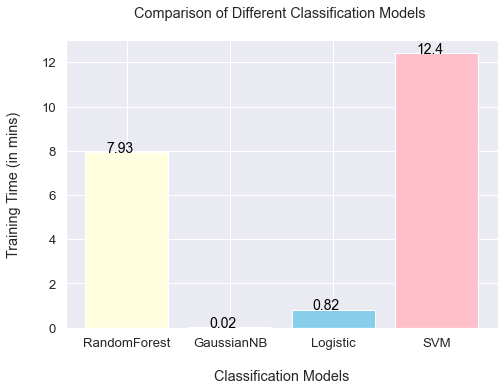

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ['RandomForest', 'GaussianNB', 'Logistic', 'SVM']
TrainingTime=[rf_tt,gnb_tt,lr_tt,svm_tt]
ax.bar(Models,TrainingTime,color=["lightyellow","lightgreen", "skyblue", "pink"]);
for i in ax.patches:
    ax.text(i.get_x()+.2, i.get_height(), str(round(i.get_height(),2)), fontsize=14, color='black')
plt.title('Comparison of Different Classification Models \n');
plt.ylabel('Training Time (in mins)\n');
plt.xlabel('\nClassification Models');

plt.show();